In [2]:
import numpy as np
import pandas as pd
import statsmodels.tsa.seasonal as STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from IPython.display import display

testData_01 = pd.read_csv("./TestdatenSet1.csv")
print(testData_01)

# Do one with electrity and one with voltage
# If conditional based on external and internal usage


       Id              Zeitstempel MaschinenID           MachineLabel  \
0      96  2025-08-04 10:49:15.287  HELLER_PT5  IGH_ProfiTrainer_PT16   
1      97  2025-08-04 11:22:01.020  HELLER_PT5  IGH_ProfiTrainer_PT16   
2      98  2025-08-04 11:24:27.807  HELLER_PT5  IGH_ProfiTrainer_PT16   
3      99  2025-08-04 11:26:07.867  HELLER_PT5  IGH_ProfiTrainer_PT16   
4     100  2025-08-04 11:30:28.233  HELLER_PT5  IGH_ProfiTrainer_PT16   
..    ...                      ...         ...                    ...   
995  1091  2025-08-21 12:19:32.197  HELLER_PT5  IGH_ProfiTrainer_PT16   
996  1092  2025-08-21 12:19:39.117  HELLER_PT5  IGH_ProfiTrainer_PT16   
997  1093  2025-08-21 12:19:44.327  HELLER_PT5  IGH_ProfiTrainer_PT16   
998  1094  2025-08-21 12:19:49.933  HELLER_PT5  IGH_ProfiTrainer_PT16   
999  1095  2025-08-21 12:23:37.007  HELLER_PT5  IGH_ProfiTrainer_PT16   

        OrderID  ConfirmationID MaterialID Tools  Component    ProgramName  \
0    60006833.0        220621.0     SP3789   

In [ ]:
def createTimeSeriesDataFrame(data, depVar,renameDepVar, isGermany):
    # The reason why timestamp is "uninteristing" as the index is due drill length already dictating the equidistance rather then the timestamp
    dataFrame = data[[depVar]].copy() # I like not mutating the original dataset; leave it as it were and create a new one with the wanted independent variable
    if renameDepVar:
        dataFrame.rename(columns={depVar:renameDepVar}, inplace=True)
    
    if isGermany: 
        dataFrame[renameDepVar] = dataFrame[renameDepVar].str.replace(",", ".", regex=False) # German floating point numbers are written with a "," instead of "."
                                                                                                # this fact tends to crash methods
    
    dataFrame[renameDepVar] = pd.to_numeric(dataFrame[renameDepVar], errors="raise") # turns all values in the renamDepVar coloumn numeric and enforeces NaN for 
                                                                                     # errors
    return dataFrame

testData_01_power_df = createTimeSeriesDataFrame(testData_01, "Strom", "Power", True)
print(testData_01_power_df)


     Power
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
..     ...
995    NaN
996    NaN
997    NaN
998    NaN
999  2.205

[1000 rows x 1 columns]


In [ ]:
#Missing Value handler Methods, before any sort of stationarity techniques come

In [11]:
#transformation, Should implement Box Cox if automated
testData_01_power_df["Power"] = np.log(testData_01_power_df["Power"])
display(testData_01_power_df)

,Power
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
995,NaN
996,NaN
997,NaN
998,NaN


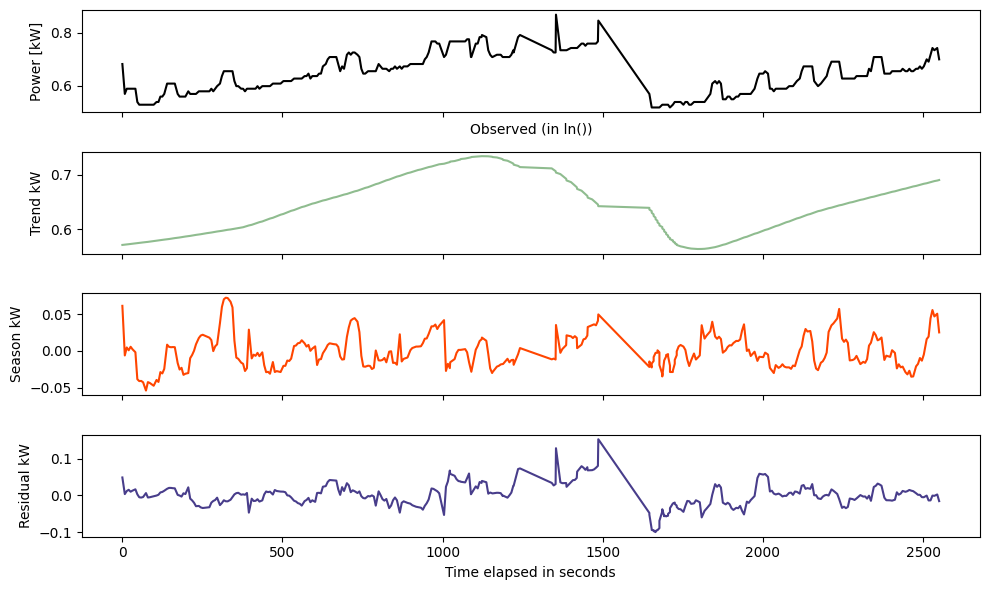

           PowerDifference
Timestamp                 
0.000             0.633197
7.626             0.566198
13.733            0.577489
19.753            0.574104
25.780            0.579314
...                    ...
2523.443          0.730372
2529.466          0.742662
2535.463          0.734913
2544.383          0.739622
2550.403          0.715179

[364 rows x 1 columns]


In [5]:
# first step stl
testData_01_power_df = testData_01_power_df.sort_index() #does that even make sense? It did although I assumed data was ordered in the csv file
# trend = math.ceil(1.5*60/(1- 1.5/301))
stl_testData_power = STL.STL(testData_01_power_df["Power"], period=60)
res = stl_testData_power.fit()

fig, axes = plt.subplots(4, 1, figsize=(10,6), sharex=True)
axes[0].plot(testData_01_power_df.index, res.observed, color="black")
axes[0].set_ylabel("Power [kW]")
axes[0].set_xlabel("Observed (in ln())")

axes[1].plot(testData_01_power_df.index, res.trend, color="darkseagreen")
axes[1].set_ylabel("Trend kW")

axes[2].plot(testData_01_power_df.index, res.seasonal, color="orangered")
axes[2].set_ylabel("Season kW")

axes[3].plot(testData_01_power_df.index, res.resid, color="darkslateblue")
axes[3].set_ylabel("Residual kW")
axes[3].set_xlabel("Time elapsed in seconds")

plt.tight_layout()
plt.show()

# Detrending as there not really seasons; remember that STL assumes seasonal>=7; reverse log operations for forecasting values
# Migh need to exp() later
detrended_data_df = pd.DataFrame(res.observed - res.resid)
detrended_data_df.rename(columns={0 : "PowerDifference"}, inplace=True)
print(detrended_data_df)

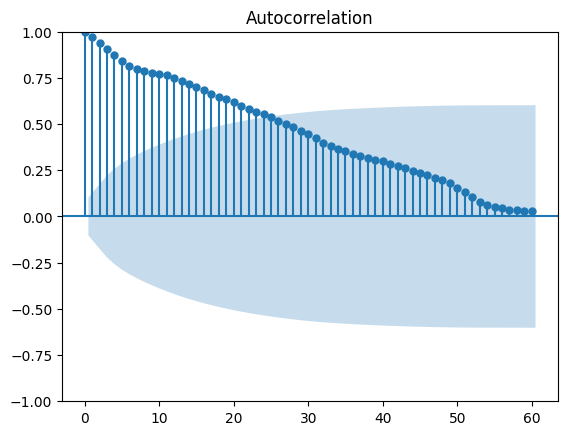

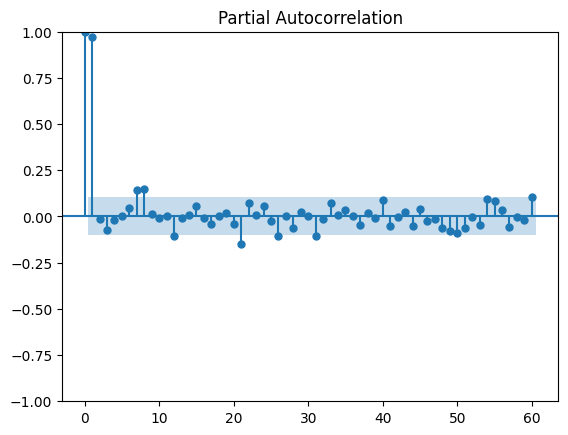

           PowerDifference
Timestamp                 
7.626            -0.066999
13.733            0.011291
19.753           -0.003384
25.780            0.005209
31.780           -0.003004
...                    ...
2523.443          0.025799
2529.466          0.012290
2535.463         -0.007749
2544.383          0.004709
2550.403         -0.024443

[363 rows x 1 columns]


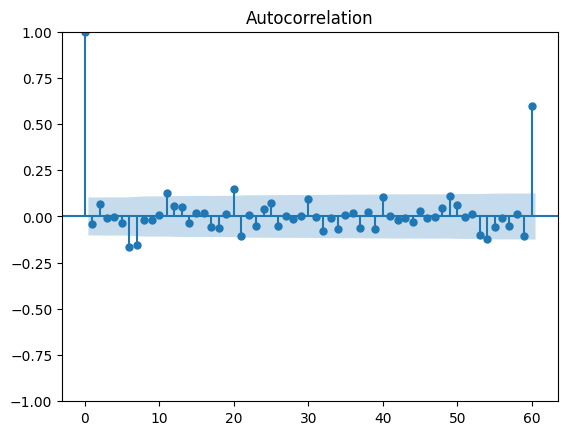

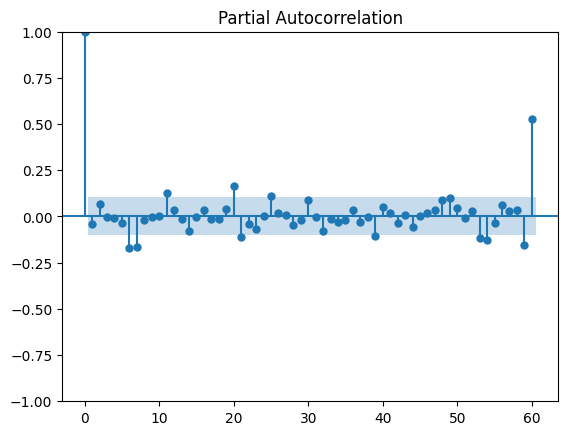

In [6]:
#stationary testing via ACF and PACF analysis
plot_acf(detrended_data_df["PowerDifference"], lags=60)
plt.show()
plot_pacf(detrended_data_df["PowerDifference"], lags=60)
plt.show()
# maybe higher order differencing as the PACF
differed_series = pd.DataFrame(detrended_data_df["PowerDifference"].diff().dropna())
print(differed_series)
plot_acf(differed_series["PowerDifference"], lags=60)
plt.show
plot_pacf(differed_series, lags=60)
plt.show()


In [7]:
# ARIMA
arima_Model = ARIMA(detrended_data_df["PowerDifference"], order=(2,1,0))
arima_Result = arima_Model.fit()
print(arima_Result.summary())
forecast = arima_Result.forecast(steps=50)
print(np.exp(forecast))

                               SARIMAX Results                                
Dep. Variable:        PowerDifference   No. Observations:                  364
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1056.845
Date:                Thu, 11 Sep 2025   AIC                          -2107.691
Time:                        14:35:35   BIC                          -2096.008
Sample:                             0   HQIC                         -2103.047
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0398      0.047     -0.853      0.394      -0.131       0.052
ar.L2          0.0739      0.103      0.718      0.473      -0.128       0.276
sigma2         0.0002      6e-06     28.843      0.0

c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scik

In [8]:
# implementation with a dropped time index
detrended_dropped_index = detrended_data_df.reset_index(drop=True).copy()
arima_Model = ARIMA(detrended_dropped_index["PowerDifference"], order=(2,1,0))
arima_Result = arima_Model.fit()
print(arima_Result.summary())
forecast = arima_Result.forecast(steps=50)
print(np.exp(forecast))

                               SARIMAX Results                                
Dep. Variable:        PowerDifference   No. Observations:                  364
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1056.845
Date:                Thu, 11 Sep 2025   AIC                          -2107.691
Time:                        14:35:35   BIC                          -2096.008
Sample:                             0   HQIC                         -2103.047
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0398      0.047     -0.853      0.394      -0.131       0.052
ar.L2          0.0739      0.103      0.718      0.473      -0.128       0.276
sigma2         0.0002      6e-06     28.843      0.0

In [ ]:
#code graveyard: you never know

# Strom pipeline
# testData_01_power_df = testData_01[["Zeitstempel", "Strom"]].copy()
# # We will assume for now that NaN is equivalent to the machine just not running; optional: we could try to build a missing value handler 
# # based on linear interpolation (does that even make sense with electricity?) or maybe by estimating a value via loess regression
# # set up dataframe with timestamp as an index 
# testData_01_power_df.rename(columns= {"Zeitstempel": "Timestamp", "Strom": "Power"}, inplace = True)
# testData_01_power_df["Power"] = testData_01_power_df["Power"].str.replace(",", ".", regex=False) # german output contains "," which crashes stl afterwards
# testData_01_power_df["Power"] = pd.to_numeric(testData_01_power_df["Power"], errors = "raise") # if errors then its put into an NaN state
# testData_01_power_df.dropna(subset=["Power"], inplace = True)   #drop all rows containing NaN values in Power coloumn

# # setting up index and interpolate to get missing values 
# testData_01_power_df["Timestamp"] = pd.to_datetime(testData_01_power_df["Timestamp"])
# testData_01_power_df.set_index("Timestamp", inplace=True)
# print(testData_01_power_df)

# testData_01_power_df.index = (testData_01_power_df.index  - testData_01_power_df.index[0]).total_seconds()
# testData_01_power_df.drop(testData_01_power_df.index[-1], inplace=True) # dropped as that row was two days later or something
# display(testData_01_power_df)